In [1]:
import numpy as np
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sampling_method import random_sampling, population_annealing
from DoS_estimation import dos_estimation
from hellinger_distance import hellinger_distance

In [2]:
with open('true_distribution_df_range51.pickle', 'rb') as p:
    true_distribution_df = pickle.load(p)

In [3]:
range_num = int(len(true_distribution_df)**(1/4))               #number of levels of each input parameters
randnum_list = [1000, 2000, 5000, 10000, 20000, 50000, 100000]  #list of number of sampling in each trials
trial_num = 5                                                   #number of trial

In [4]:
rsdf_list = []                                                  #list of results of each random_num 
for random_num in randnum_list:
    rs = random_sampling(true_distribution_df, range_num, random_num)
    random_sampling_df = rs.random_sample_from_df(trial_num)
    rsdf_list.append(random_sampling_df)

In [5]:
range_num = int(len(true_distribution_df)**(1/4))  #number of levels of each input parameters
walk_step = 5                                      #number of random walk step (+-)
bnum = 10                                          #number of levels of inverse temperature
betas = np.linspace(0.1,20,num=bnum)               #inverse tenmeratures
mcmc_num = 20                                      #number of mcmc steps of each particles in one temperature
numpop_list = [5, 10, 25, 50, 100, 250, 500]       #list of number of population
trial_num = 5                                      #number of trial

In [6]:
esdf_list = []                                     #list of results of each num_population
for num_population in numpop_list:
    pa = population_annealing(true_distribution_df,range_num,num_population,mcmc_num,walk_step,betas)
    EPA_sampling_df, _ = pa.pupolation_annealing_from_df(trial_num)
    esdf_list.append(EPA_sampling_df)

In [7]:
#set DoS range and levels
energy_max = 1
energy_min = 0
energy_level = 1000

dos_est = dos_estimation(energy_max, energy_min, energy_level)

In [8]:
#Calculate true DoS
true_dos = dos_est.dos_from_true(true_distribution_df['Total_failure'])

#Estimation of DoS from random samples
rs_dos_list = []
for random_sampling_df in rsdf_list: 
    dos_list = []
    for trial in range(trial_num):
        energy_data = random_sampling_df[random_sampling_df['trial']==trial]['Total_failure']
        random_dos = dos_est.dos_from_random(energy_data)
        dos_list.append(random_dos)
    rs_dos_list.append(dos_list)
    
#Estimation of DoS from EPA
mhm_iter = 100                                     #iteration of multiple histogram method
energy_column = 'Total_failure'                    #dos target outputs (outputs used for epa optimization)
es_dos_list = []
es_f_lsit = []
for EPA_sampling_df in esdf_list: 
    dos_list = []
    f_list = []
    for trial in range(trial_num):
        EPA_samples = EPA_sampling_df[EPA_sampling_df['trial']==trial]
        EPA_dos, EPA_f = dos_est.dos_from_epa(betas, EPA_samples, energy_column, mhm_iter)
        dos_list.append(EPA_dos)
        f_list.append(EPA_f)
    es_dos_list.append(dos_list)
    es_f_lsit.append(f_list)

In [9]:
thres_list = [10**value for value in np.arange(-2,0.1,0.5)]       #energy threshold point for Hellinger comparison
hg = hellinger_distance(true_dos)

#Hellinger distance of DoS estimated by random samples with different sample size
rs_dos_hellingers = []
for dos_list in rs_dos_list:
    rs_hellinger_df = hg.hellinger_for_plot(dos_list, thres_list)
    rs_dos_hellingers.append(rs_hellinger_df)
    
#Hellinger distance of DoS estimated by EPA with different sample size
es_dos_hellingers = []
for dos_list in es_dos_list:
    es_hellinger_df = hg.hellinger_for_plot(dos_list, thres_list)
    es_dos_hellingers.append(es_hellinger_df)

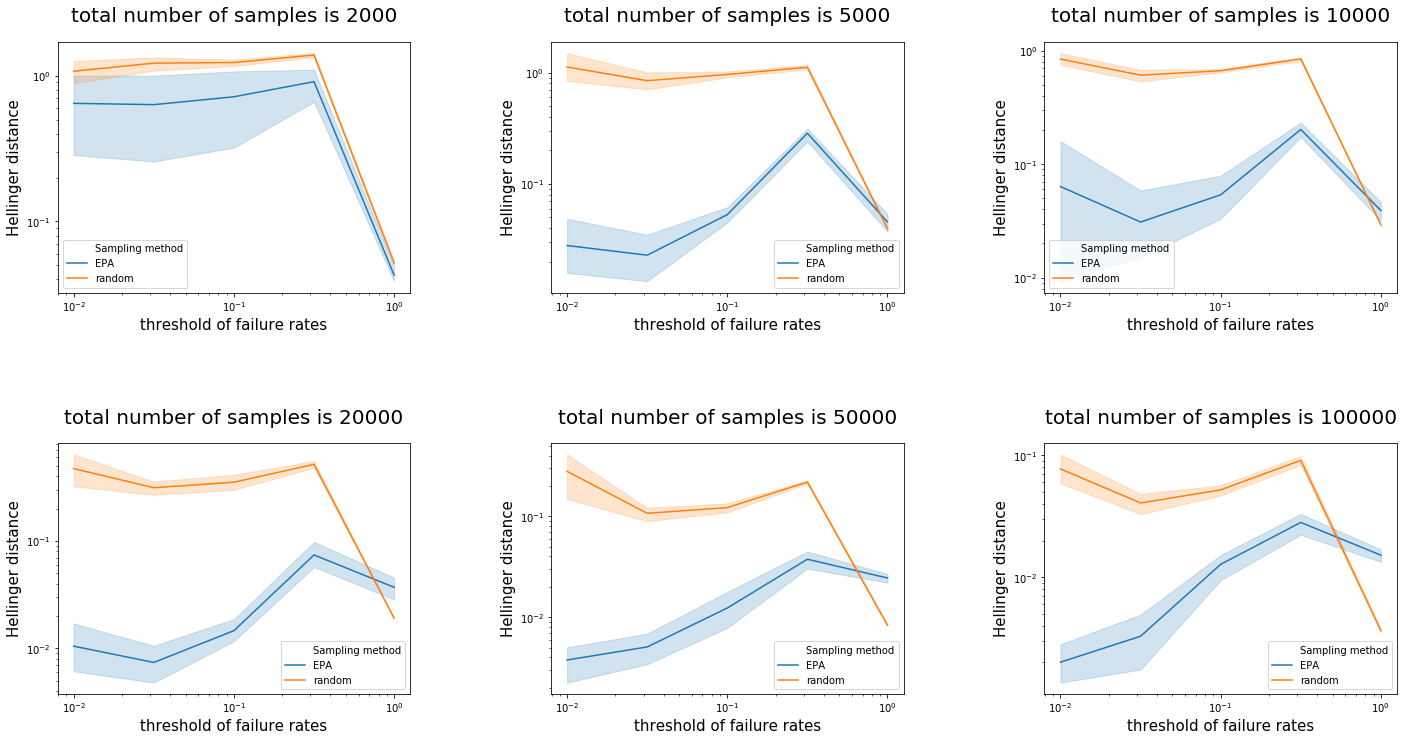

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(24,12))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
total_number_list = [1000, 2000, 5000, 10000, 20000, 50000, 100000]

for _i in range(len(es_dos_hellingers)-1):
    i = _i+1
    row = _i//3
    col = _i%3
    es_dos_hellingers[i]['Sampling method'] = 'EPA'
    rs_dos_hellingers[i]['Sampling method'] = 'random'
    helinger_compare_df = pd.concat((es_dos_hellingers[i],rs_dos_hellingers[i]))
    helinger_compare_df = pd.melt(helinger_compare_df, id_vars='Sampling method', var_name='threshold', value_name='hellinger distance')
    sns.lineplot(data=helinger_compare_df, x="threshold", y="hellinger distance", hue="Sampling method", markers=True, ax=ax[row,col])
    ax[row,col].set_xscale('log')
    ax[row,col].set_yscale('log')
    ax[row,col].set_xlabel("threshold of failure rates", fontsize=15)
    ax[row,col].set_ylabel("Hellinger distance", fontsize=15)
    ax[row,col].set_title('total number of samples is {}'.format(total_number_list[i]), fontsize=20, pad=20)

In [11]:
with open("rs_samples_diff_size_51.pickle", mode="wb") as fi:
    pickle.dump(rsdf_list, fi)
with open("es_samples_diff_size_51.pickle", mode="wb") as fi:
    pickle.dump(esdf_list, fi)
with open("rs_dos_diff_size_51.pickle", mode="wb") as fi:
    pickle.dump(rs_dos_list, fi)
with open("es_dos_diff_size_51.pickle", mode="wb") as fi:
    pickle.dump(es_dos_list, fi)
with open("es_f_diff_size_51.pickle", mode="wb") as fi:
    pickle.dump(es_f_lsit, fi)